In [1]:
!pip install transformers torch pandas scikit-learn

In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import logging



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv("/kaggle/input/dataset/final_dataset")

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Initialize the LabelEncoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(data['Sentiment'])  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        review = self.data.iloc[idx]['reviewText']
        sentiment = self.data.iloc[idx]['Sentiment']

        encoding = self.tokenizer(review, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        #to convert sentiment labels to numerical labels
        sentiment = self.label_encoder.transform([sentiment])[0]

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(sentiment, dtype=torch.long)  
        }


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU.")
    
# Split dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    
# Initialize the XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

max_len=400

# Encode the dataset
train_dataset = CustomDataset(train_df, tokenizer, max_len)
test_dataset = CustomDataset(val_df, tokenizer,max_len)

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3)  # 3 labels: Positive, Negative, Neutral

# Moving the model to the selected device
model = model.to(device)

GPU is available.


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
#Data loaders
batch_size = 20 # no of batches: 14400/20=720
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

Epoch 1/5: 100%|██████████| 720/720 [33:05<00:00,  2.76s/it]


Epoch 1/5 - Average Loss: 0.6769 - Accuracy: 80.56%


Epoch 2/5: 100%|██████████| 720/720 [33:10<00:00,  2.76s/it]


Epoch 2/5 - Average Loss: 0.4394 - Accuracy: 84.00%


Epoch 3/5: 100%|██████████| 720/720 [33:08<00:00,  2.76s/it]


Epoch 3/5 - Average Loss: 0.2810 - Accuracy: 88.69%


Epoch 4/5: 100%|██████████| 720/720 [33:10<00:00,  2.76s/it]


Epoch 4/5 - Average Loss: 0.1767 - Accuracy: 89.22%


Epoch 5/5: 100%|██████████| 720/720 [33:09<00:00,  2.76s/it]


Epoch 5/5 - Average Loss: 0.1067 - Accuracy: 89.86%


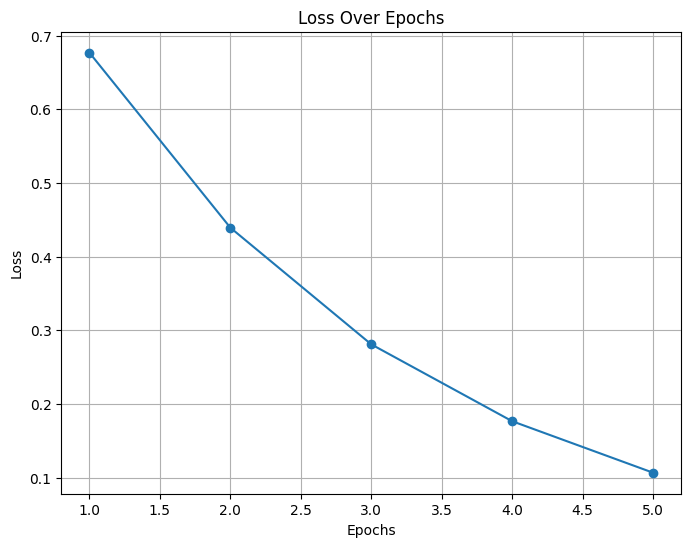

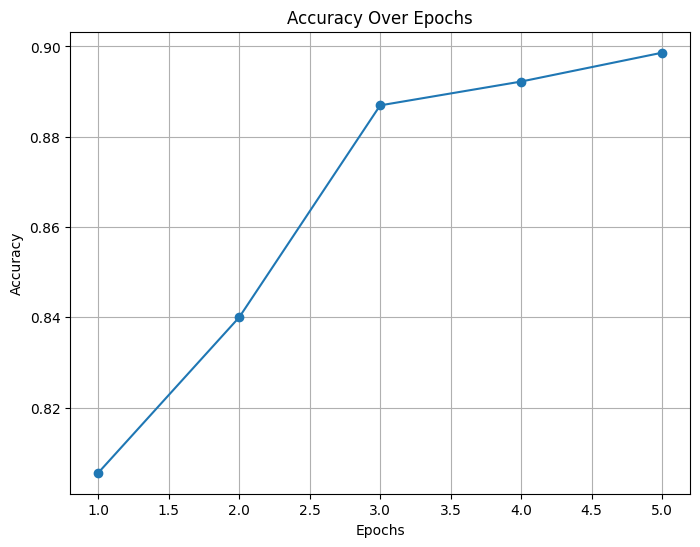

In [6]:
import matplotlib.pyplot as plt

# Lists to store loss and accuracy values for each epoch
loss_values = []
accuracy_values = []

torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", dynamic_ncols=True):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)

    logging.info(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {average_loss:.4f}")

    # Calculate and store accuracy
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predicted_labels = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predicted_labels == labels).item()
            total_predictions += len(labels)

    accuracy = correct_predictions / total_predictions
    accuracy_values.append(accuracy)
    loss_values.append(average_loss)

    model.save_pretrained(f'trained_model_epoch_{epoch + 1}')

    print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {average_loss:.4f} - Accuracy: {accuracy * 100:.2f}%")

model.save_pretrained('trained_model')
torch.save(model.state_dict(), 'my_model.pth')

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), accuracy_values, marker='o', linestyle='-')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
